In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#from keras.models import *
from keras.models import Sequential, Model  # Importar Model para modelos funcionales
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import numpy as np
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Input  # Importar Input para definir la entrada
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt

In [3]:
#Carga de datos de los diferentes CSV´s
patient_data = pd.read_csv('PatientCorePopulatedTable.txt', sep='\t') 
labs_data = pd.read_csv('LabsCorePopulatedTable.txt', sep='\t')
diagnosis_data = pd.read_csv('AdmissionsDiagnosesCorePopulatedTable.txt', sep='\t')
admisions_data = pd.read_csv('AdmissionsCorePopulatedTable.txt', sep='\t')

In [4]:
#Para poder unir las tablas, necesitamos concatenar PatientID con su correpondiente AdmissionId para tener una clave única que relacione las tablas
labs_data["P+A"] = labs_data["PatientID"] + labs_data["AdmissionID"].map(str)
diagnosis_data["P+A"] = diagnosis_data["PatientID"] + diagnosis_data["AdmissionID"].map(str)
admisions_data["P+A"] = admisions_data["PatientID"] + admisions_data["AdmissionID"].map(str)

In [5]:
#Pivotamos la tabla de datos de laboratorio para que cada prueba sea una columna en lugar de una fila
labs_data_pivote = labs_data.pivot_table(index='P+A', columns=['LabName','LabUnits'], values='LabValue')

In [6]:
#Para no tener dos niveles, concatenamos LabName y LabUnits
labs_data_pivote.columns = pd.MultiIndex.from_tuples(labs_data_pivote.columns, names=['LabName', 'LabUnits'])

# Concatenar los nombres de los niveles y establecer como índice único
labs_data_pivote.columns = labs_data_pivote.columns.get_level_values('LabName') + ' (' + labs_data_pivote.columns.get_level_values('LabUnits') + ')'

In [7]:
#Mergeamos labs_data_pivote y diagnosis_data
merged_df = pd.merge(labs_data_pivote, diagnosis_data, on='P+A')

#Mergeamos el anterior df con admisions_data
merged_df = pd.merge(merged_df, admisions_data, on='P+A', how='outer')

In [8]:
merged_df.columns

Index(['P+A', 'CBC: ABSOLUTE LYMPHOCYTES (%)', 'CBC: ABSOLUTE NEUTROPHILS (%)',
       'CBC: BASOPHILS (k/cumm)', 'CBC: EOSINOPHILS (k/cumm)',
       'CBC: HEMATOCRIT (%)', 'CBC: HEMOGLOBIN (gm/dl)',
       'CBC: LYMPHOCYTES (k/cumm)', 'CBC: MCH (pg)', 'CBC: MCHC (g/dl)',
       'CBC: MEAN CORPUSCULAR VOLUME (fl)', 'CBC: MONOCYTES (k/cumm)',
       'CBC: NEUTROPHILS (k/cumm)', 'CBC: PLATELET COUNT (k/cumm)',
       'CBC: RDW (%)', 'CBC: RED BLOOD CELL COUNT (m/cumm)',
       'CBC: WHITE BLOOD CELL COUNT (k/cumm)', 'METABOLIC: ALBUMIN (gm/dL)',
       'METABOLIC: ALK PHOS (U/L)', 'METABOLIC: ALT/SGPT (U/L)',
       'METABOLIC: ANION GAP (mmol/L)', 'METABOLIC: AST/SGOT (U/L)',
       'METABOLIC: BILI TOTAL (mg/dL)', 'METABOLIC: BUN (mg/dL)',
       'METABOLIC: CALCIUM (mg/dL)', 'METABOLIC: CARBON DIOXIDE (mmol/L)',
       'METABOLIC: CHLORIDE (mmol/L)', 'METABOLIC: CREATININE (mg/dL)',
       'METABOLIC: GLUCOSE (mg/dL)', 'METABOLIC: POTASSIUM (mmol/L)',
       'METABOLIC: SODIUM (mmol/L

In [9]:
#Eliminamos la duplicidad creada en PatientID
merged_df['PatientID'] = merged_df['PatientID_x']

In [10]:
# Luego, fusionamos el resultado con el tercer DataFrame
merged_df = pd.merge(merged_df, patient_data, on='PatientID', how='outer')

In [11]:
#Calculamos la edad de cada paciente en el momento de la admisión
merged_df['Edad'] = 2024 - pd.to_datetime(merged_df['PatientDateOfBirth']).dt.year

In [12]:
merged_df.columns

Index(['P+A', 'CBC: ABSOLUTE LYMPHOCYTES (%)', 'CBC: ABSOLUTE NEUTROPHILS (%)',
       'CBC: BASOPHILS (k/cumm)', 'CBC: EOSINOPHILS (k/cumm)',
       'CBC: HEMATOCRIT (%)', 'CBC: HEMOGLOBIN (gm/dl)',
       'CBC: LYMPHOCYTES (k/cumm)', 'CBC: MCH (pg)', 'CBC: MCHC (g/dl)',
       'CBC: MEAN CORPUSCULAR VOLUME (fl)', 'CBC: MONOCYTES (k/cumm)',
       'CBC: NEUTROPHILS (k/cumm)', 'CBC: PLATELET COUNT (k/cumm)',
       'CBC: RDW (%)', 'CBC: RED BLOOD CELL COUNT (m/cumm)',
       'CBC: WHITE BLOOD CELL COUNT (k/cumm)', 'METABOLIC: ALBUMIN (gm/dL)',
       'METABOLIC: ALK PHOS (U/L)', 'METABOLIC: ALT/SGPT (U/L)',
       'METABOLIC: ANION GAP (mmol/L)', 'METABOLIC: AST/SGOT (U/L)',
       'METABOLIC: BILI TOTAL (mg/dL)', 'METABOLIC: BUN (mg/dL)',
       'METABOLIC: CALCIUM (mg/dL)', 'METABOLIC: CARBON DIOXIDE (mmol/L)',
       'METABOLIC: CHLORIDE (mmol/L)', 'METABOLIC: CREATININE (mg/dL)',
       'METABOLIC: GLUCOSE (mg/dL)', 'METABOLIC: POTASSIUM (mmol/L)',
       'METABOLIC: SODIUM (mmol/L

In [13]:
# Eliminar Columnas No Necesarias
merged_df.drop(['P+A', 'PatientDateOfBirth', 'PatientID_x', 'PatientID_y',
                'PrimaryDiagnosisDescription', 'PatientPopulationPercentageBelowPoverty',
                'AdmissionID_x', 'AdmissionID_y'
              ], axis=1, inplace=True)

In [14]:
# Función para determinar el capítulo basado en el diagnóstico
def obtener_capitulo(diagnostico):
    # Extraemos los primeros tres caracteres del diagnóstico
    codigo = diagnostico[:3]
    # Convertimos el código a un número
    codigo_num = ord(codigo[0]) * 100 + int(codigo[1:2])

    # Definimos los rangos y capítulos usando los valores ordinales
    capitulos = [
        (ord('A') * 100, ord('B') * 100 + 99, '1'),
        (ord('C') * 100, ord('D') * 100 + 48, '2'),
        (ord('D') * 100 + 50, ord('D') * 100 + 89, '3'),
        (ord('E') * 100, ord('E') * 100 + 90, '4'),
        (ord('F') * 100, ord('F') * 100 + 99, '5'),
        (ord('G') * 100, ord('G') * 100 + 99, '6'),
        (ord('H') * 100, ord('H') * 100 + 59, '7'),
        (ord('H') * 100 + 60, ord('H') * 100 + 95, '8'),
        (ord('I') * 100, ord('I') * 100 + 99, '9'),
        (ord('J') * 100, ord('J') * 100 + 99, '10'),
        (ord('K') * 100, ord('K') * 100 + 93, '11'),
        (ord('L') * 100, ord('L') * 100 + 99, '12'),
        (ord('M') * 100, ord('M') * 100 + 99, '13'),
        (ord('N') * 100, ord('N') * 100 + 99, '14'),
        (ord('O') * 100, ord('O') * 100 + 99, '15'),
        (ord('P') * 100, ord('P') * 100 + 96, '16'),
        (ord('Q') * 100, ord('Q') * 100 + 99, '17'),
        (ord('R') * 100, ord('R') * 100 + 99, '18'),
        (ord('S') * 100, ord('T') * 100 + 98, '19'),
        (ord('V') * 100, ord('Y') * 100 + 98, '20'),
        (ord('Z') * 100, ord('Z') * 100 + 99, '21'),
        (ord('U') * 100, ord('U') * 100 + 99, '22')
    ]

    # Comparamos el código numérico con los rangos definidos
    for inicio, fin, capitulo in capitulos:
        if inicio <= codigo_num <= fin:
            return capitulo
    return 'Capítulo no encontrado'

# Aplicamos la función a la columna de diagnósticos
merged_df['PrimaryDiagnosisChapter'] = merged_df['PrimaryDiagnosisCode'].apply(obtener_capitulo)

In [15]:
#Aplicamos OneHot encoder a las variables que no tienen demasiados datos distintos
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder()

# Ajustar y transformar las columnas 'PatientGender' y 'PatientMaritalStatus' con el encoder
encoded_columns = encoder.fit_transform(merged_df[['PatientGender', 'PatientMaritalStatus']])

# Convertir el resultado en una matriz densa
encoded_columns_dense = encoded_columns.toarray()

# Obtener los nombres de las nuevas columnas
column_names = encoder.get_feature_names_out(['PatientGender', 'PatientMaritalStatus'])

# Crear el DataFrame con los datos codificados y los nombres de columnas correctos
encoded_df = pd.DataFrame(encoded_columns_dense, columns=column_names)

# Concatenar el DataFrame codificado con el original, excluyendo las columnas originales
merged_df = pd.concat([merged_df.drop(['PatientGender', 'PatientMaritalStatus'], axis=1), encoded_df], axis=1)
df = merged_df
#Como no podemos utilizar el formato datetime, obtenemos dos nuevas columnas calculando AdmissionDuration y TimeSinceLastAdmision

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split


# Convertir fechas a datetime 
df['AdmissionStartDate'] = pd.to_datetime(df['AdmissionStartDate'])
df['AdmissionEndDate'] = pd.to_datetime(df['AdmissionEndDate'])

# Calcular la duración de la admisión y el tiempo desde la última admisión
df['AdmissionDuration'] = (df['AdmissionEndDate'] - df['AdmissionStartDate']).dt.total_seconds() / 3600
df = df.sort_values(['PatientID', 'AdmissionStartDate'])
df['TimeSinceLastAdmission'] = df.groupby('PatientID')['AdmissionStartDate'].diff().dt.total_seconds() / 3600


#
# Definir columnas numéricas y categóricas
numeric_columns = ['CBC: ABSOLUTE LYMPHOCYTES (%)', 'CBC: ABSOLUTE NEUTROPHILS (%)',
                   'CBC: BASOPHILS (k/cumm)', 'CBC: EOSINOPHILS (k/cumm)',
                   'CBC: HEMATOCRIT (%)', 'CBC: HEMOGLOBIN (gm/dl)',
                   'CBC: LYMPHOCYTES (k/cumm)', 'CBC: MCH (pg)', 'CBC: MCHC (g/dl)',
                   'CBC: MEAN CORPUSCULAR VOLUME (fl)', 'CBC: MONOCYTES (k/cumm)',
                   'CBC: NEUTROPHILS (k/cumm)', 'CBC: PLATELET COUNT (k/cumm)',
                   'CBC: RDW (%)', 'CBC: RED BLOOD CELL COUNT (m/cumm)',
                   'CBC: WHITE BLOOD CELL COUNT (k/cumm)', 'METABOLIC: ALBUMIN (gm/dL)',
                   'METABOLIC: ALK PHOS (U/L)', 'METABOLIC: ALT/SGPT (U/L)',
                   'METABOLIC: ANION GAP (mmol/L)', 'METABOLIC: AST/SGOT (U/L)',
                   'METABOLIC: BILI TOTAL (mg/dL)', 'METABOLIC: BUN (mg/dL)',
                   'METABOLIC: CALCIUM (mg/dL)', 'METABOLIC: CARBON DIOXIDE (mmol/L)',
                   'METABOLIC: CHLORIDE (mmol/L)', 'METABOLIC: CREATININE (mg/dL)',
                   'METABOLIC: GLUCOSE (mg/dL)', 'METABOLIC: POTASSIUM (mmol/L)',
                   'METABOLIC: SODIUM (mmol/L)', 'METABOLIC: TOTAL PROTEIN (gm/dL)',
                   'URINALYSIS: PH (no unit)', 'URINALYSIS: RED BLOOD CELLS (rbc/hpf)',
                   'URINALYSIS: SPECIFIC GRAVITY (no unit)',
                   'URINALYSIS: WHITE BLOOD CELLS (wbc/hpf)', 'Edad',
                   'AdmissionDuration', 'TimeSinceLastAdmission']

for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

#Aplicamos mapeo de frecuencia para no darle un peso quivocado a las variables
# Columnas para mapeo de frecuencia
frequency_map_columns = ['PatientLanguage', 'PrimaryDiagnosisCode', 'PatientRace']

# Aplicar mapeo de frecuencia
for col in frequency_map_columns:
    frequency_map = df[col].value_counts().to_dict()
    df[col] = df[col].map(frequency_map)

df = df.dropna(axis=0)
columns = [col for col in df.columns if col != 'PrimaryDiagnosisChapter'] + ['PrimaryDiagnosisChapter']
df = df[columns]

CBC: ABSOLUTE LYMPHOCYTES (%)  CBC: ABSOLUTE NEUTROPHILS (%)  \
0                        21.050000                      69.300000   
1                        29.850000                      72.360000   
2                        24.240000                      67.566667   
3                        22.571429                      70.925000   
4                        28.383333                      66.588889   
..                             ...                            ...   
367                      25.566667                      67.816667   
368                      25.383333                      69.800000   
369                      25.886667                      68.686667   
370                      27.800000                      68.660000   
371                      25.720000                      70.037500   

     CBC: BASOPHILS (k/cumm)  CBC: EOSINOPHILS (k/cumm)  CBC: HEMATOCRIT (%)  \
0                   0.125000                   0.275000            43.500000   
1                   0.080000                   0.400000            39.380000   
2                   0.077778                   0.322222            35.712500   
3                   0.083333                   0.233333            41.200000   
4                   0.166667                   0.357143            44.250000   
..                       ...                        ...                  ...   
367                 0.100000                   0.400000            42.442857   
368                 0.122222                   0.300000            47.200000   
369                 0.109091                   0.357143            42.676923   
370                 0.085714                   0.414286            40.614286   
371                 0.109091                   0.372727            44.027273   

     CBC: HEMOGLOBIN (gm/dl)  CBC: LYMPHOCYTES (k/cumm)  CBC: MCH (pg)  \
0                  13.060000                   3.650000      29.283333   
1                  14.875000                   3.500000      34.533333   
2                  14.350000                   2.850000      29.228571   
3                  15.087500                   3.733333      32.255556   
4                  13.155556                   3.280000      30.528571   
..                       ...                        ...            ...   
367                13.280000                   3.022222      29.150000   
368                14.800000                   2.528571      27.511111   
369                14.309091                   2.587500      29.636364   
370                13.877778                   3.360000      31.811111   
371                15.487500                   2.677778      30.522222   

     CBC: MCHC (g/dl)  CBC: MEAN CORPUSCULAR VOLUME (fl)  ...  Edad  \
0           32.280000                          83.000000  ...    64   
1           33.600000                          85.475000  ...    64   
2           32.211111                          85.460000  ...    64   
3           33.257143                          84.820000  ...    64   
4           32.944444                          80.066667  ...    64   
..                ...                                ...  ...   ...   
367         33.400000                          80.840000  ...    69   
368         32.366667                          84.875000  ...    69   
369         33.557143                          87.193333  ...    83   
370         34.154545                          83.833333  ...    83   
371         33.700000                          86.669231  ...    83   

     PrimaryDiagnosisChapter  PatientGender_Female  PatientGender_Male  \
0                         15                   0.0                 1.0   
1                          4                   0.0                 1.0   
2                          9                   0.0                 1.0   
3                         15                   0.0                 1.0   
4                          5                   0.0                 1.0   
..                       ... 

In [17]:
df.columns

Index(['CBC: ABSOLUTE LYMPHOCYTES (%)', 'CBC: ABSOLUTE NEUTROPHILS (%)',
       'CBC: BASOPHILS (k/cumm)', 'CBC: EOSINOPHILS (k/cumm)',
       'CBC: HEMATOCRIT (%)', 'CBC: HEMOGLOBIN (gm/dl)',
       'CBC: LYMPHOCYTES (k/cumm)', 'CBC: MCH (pg)', 'CBC: MCHC (g/dl)',
       'CBC: MEAN CORPUSCULAR VOLUME (fl)', 'CBC: MONOCYTES (k/cumm)',
       'CBC: NEUTROPHILS (k/cumm)', 'CBC: PLATELET COUNT (k/cumm)',
       'CBC: RDW (%)', 'CBC: RED BLOOD CELL COUNT (m/cumm)',
       'CBC: WHITE BLOOD CELL COUNT (k/cumm)', 'METABOLIC: ALBUMIN (gm/dL)',
       'METABOLIC: ALK PHOS (U/L)', 'METABOLIC: ALT/SGPT (U/L)',
       'METABOLIC: ANION GAP (mmol/L)', 'METABOLIC: AST/SGOT (U/L)',
       'METABOLIC: BILI TOTAL (mg/dL)', 'METABOLIC: BUN (mg/dL)',
       'METABOLIC: CALCIUM (mg/dL)', 'METABOLIC: CARBON DIOXIDE (mmol/L)',
       'METABOLIC: CHLORIDE (mmol/L)', 'METABOLIC: CREATININE (mg/dL)',
       'METABOLIC: GLUCOSE (mg/dL)', 'METABOLIC: POTASSIUM (mmol/L)',
       'METABOLIC: SODIUM (mmol/L)', 'ME

In [ ]:
df.to_csv('df_EDA.csv', index=False)

In [18]:
#df.drop(columns=['AdmissionStartDate', 'AdmissionEndDate', 'PrimaryDiagnosisChapter_encoded', 'PatientID', 'PrimaryDiagnosisCode'], inplace=True)

Dimensiones del dataframe: (265, 53)

Tipos de datos:
 CBC: ABSOLUTE LYMPHOCYTES (%)                     float64
CBC: ABSOLUTE NEUTROPHILS (%)                     float64
CBC: BASOPHILS (k/cumm)                           float64
CBC: EOSINOPHILS (k/cumm)                         float64
CBC: HEMATOCRIT (%)                               float64
CBC: HEMOGLOBIN (gm/dl)                           float64
CBC: LYMPHOCYTES (k/cumm)                         float64
CBC: MCH (pg)                                     float64
CBC: MCHC (g/dl)                                  float64
CBC: MEAN CORPUSCULAR VOLUME (fl)                 float64
CBC: MONOCYTES (k/cumm)                           float64
CBC: NEUTROPHILS (k/cumm)                         float64
CBC: PLATELET COUNT (k/cumm)                      float64
CBC: RDW (%)                                      float64
CBC: RED BLOOD CELL COUNT (m/cumm)                float64
CBC: WHITE BLOOD CELL COUNT (k/cumm)              float64
METABOLIC: ALBUMI

C:\Users\piran\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\piran\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\piran\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\piran\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

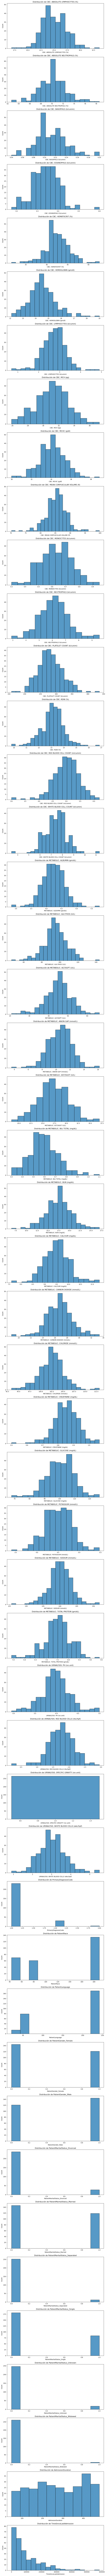

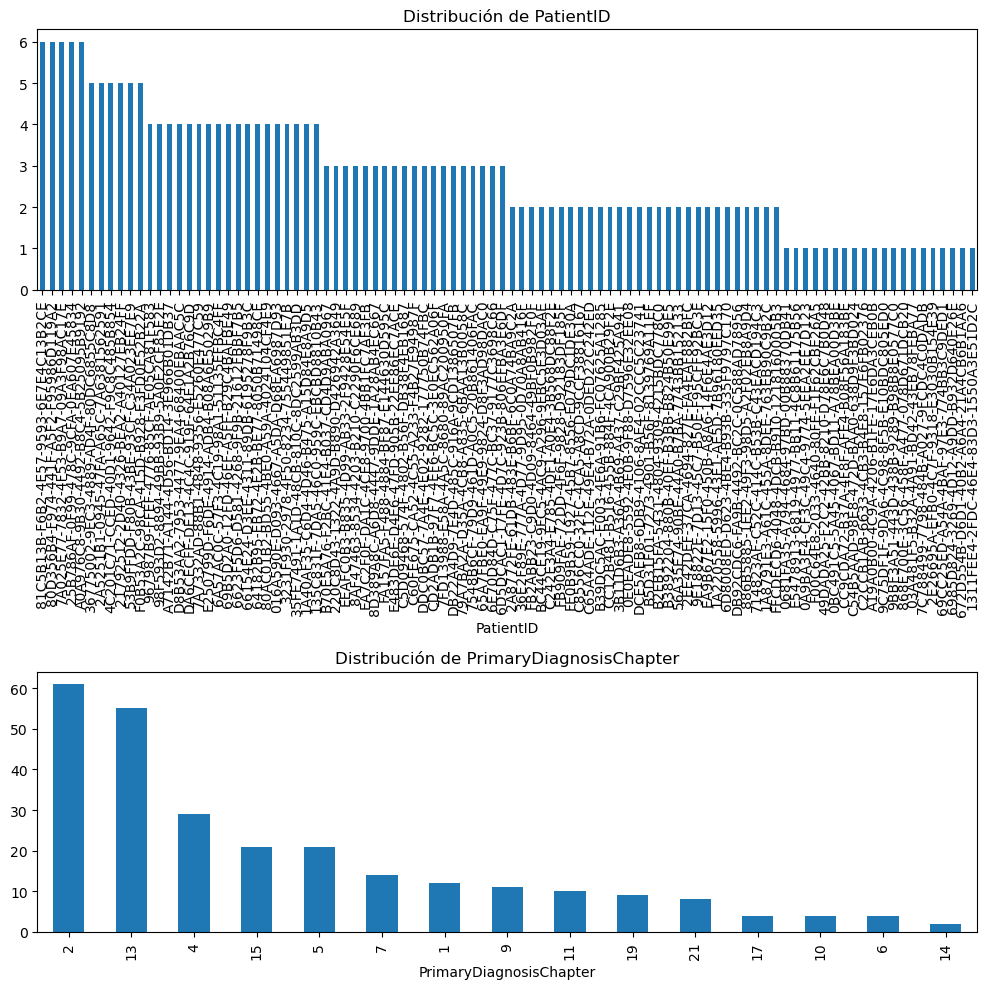

C:\Users\piran\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


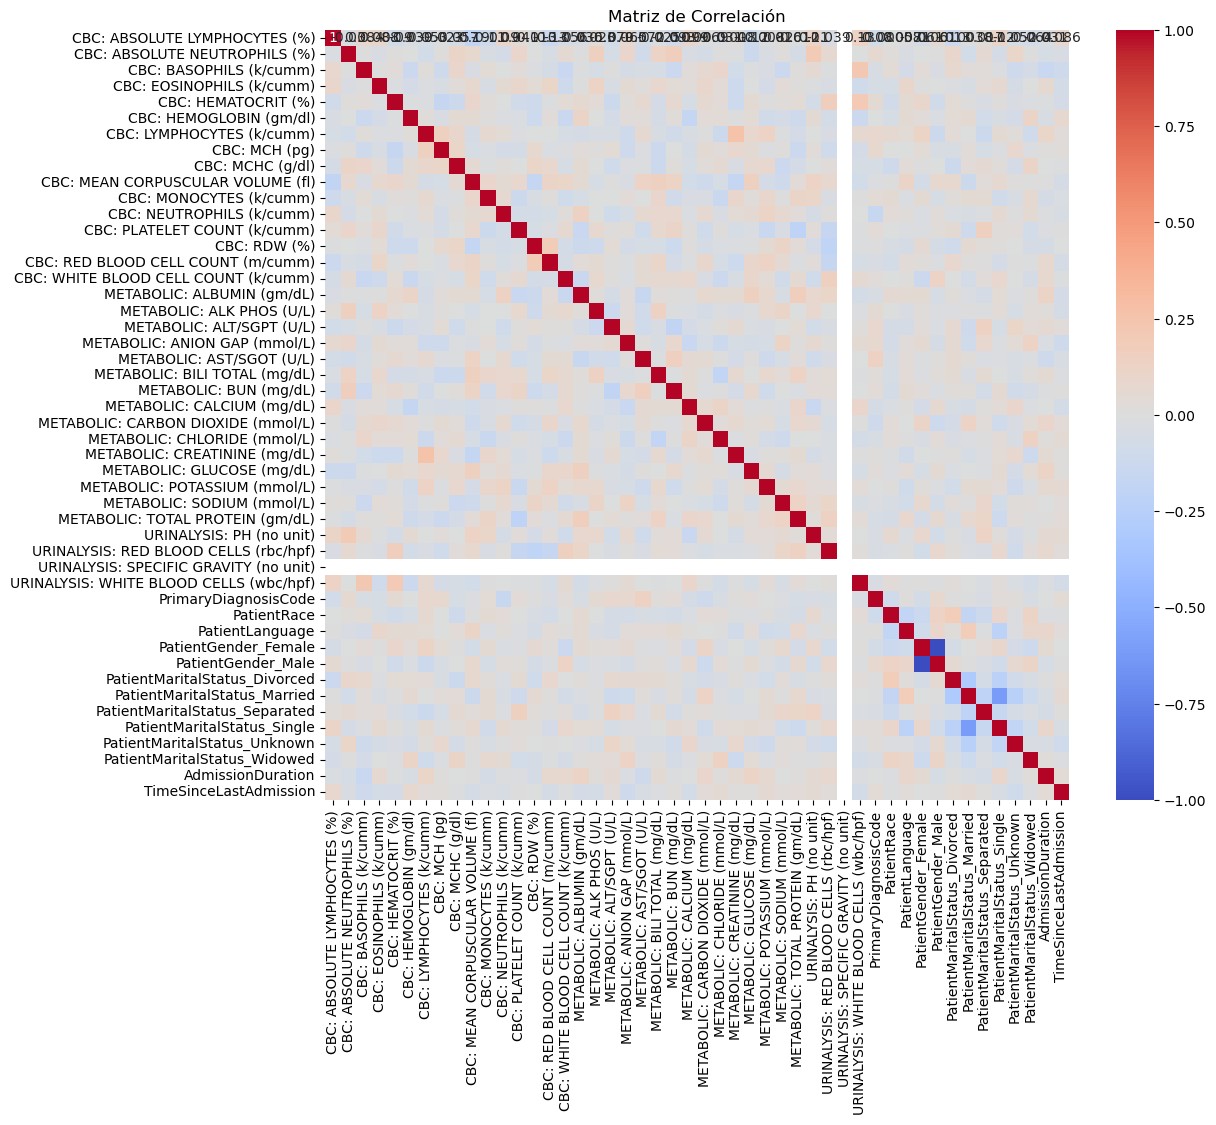

C:\Users\piran\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


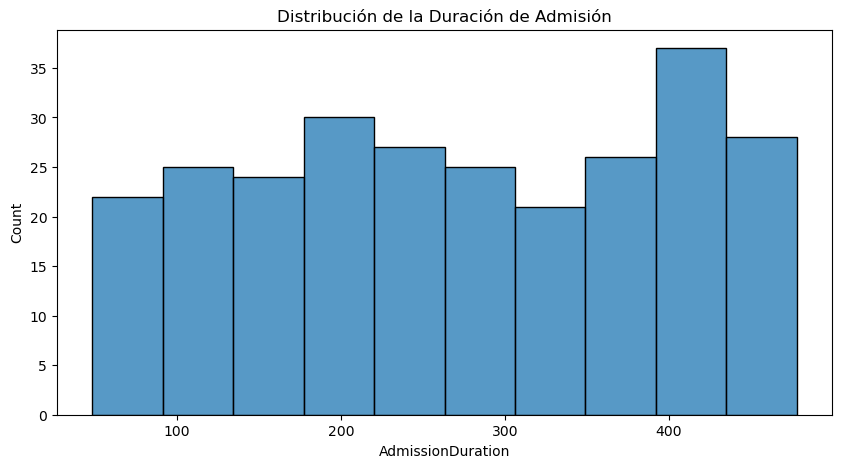

C:\Users\piran\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


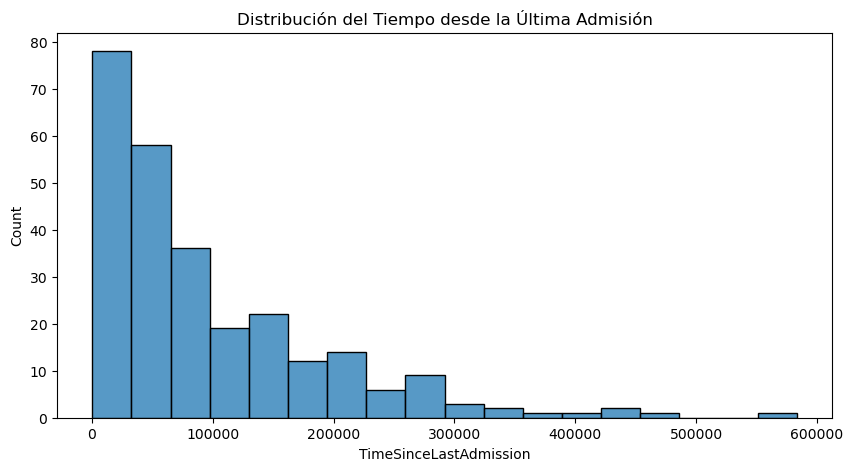

C:\Users\piran\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


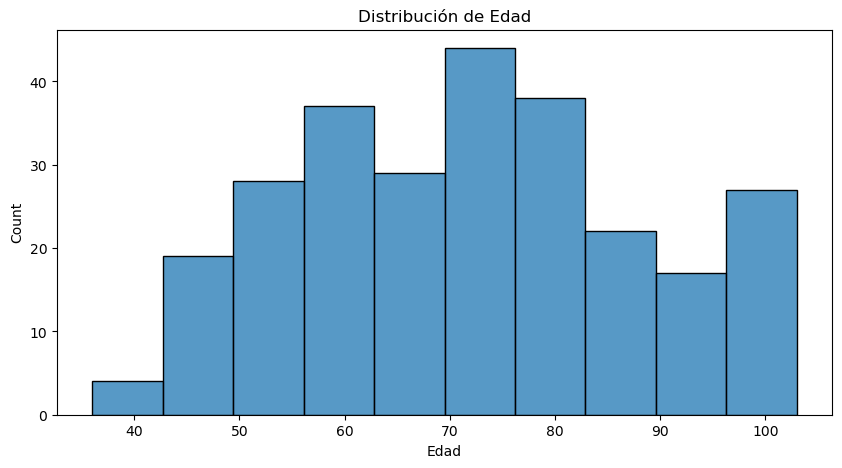

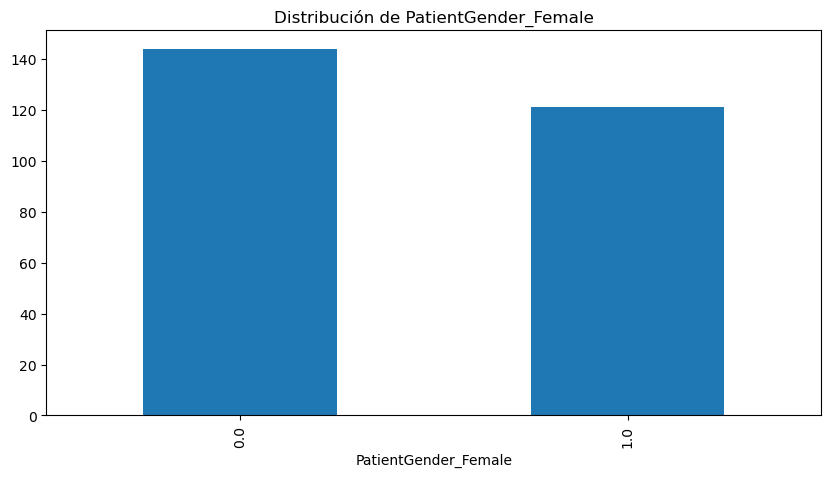

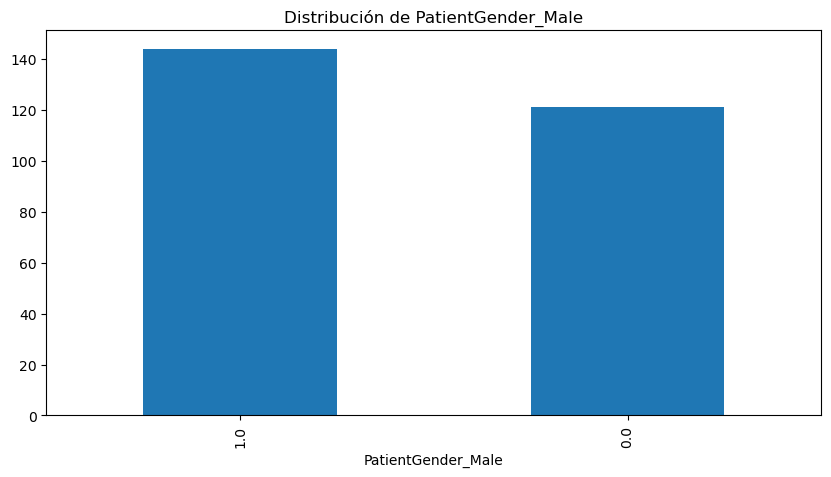

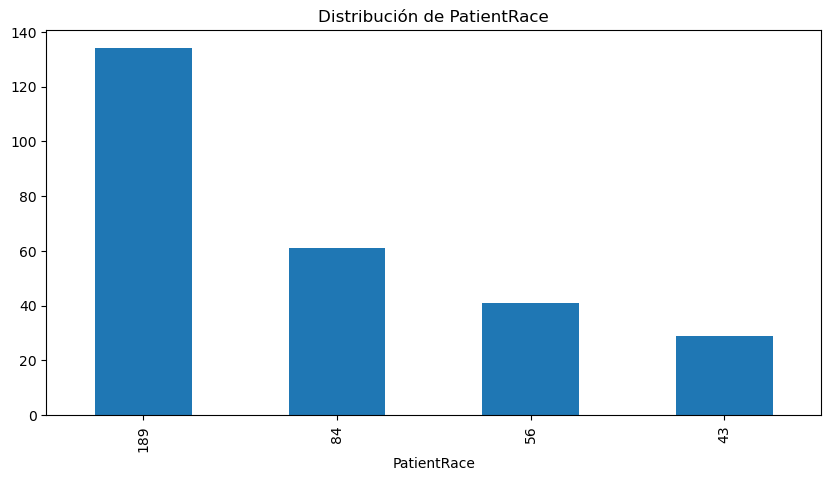

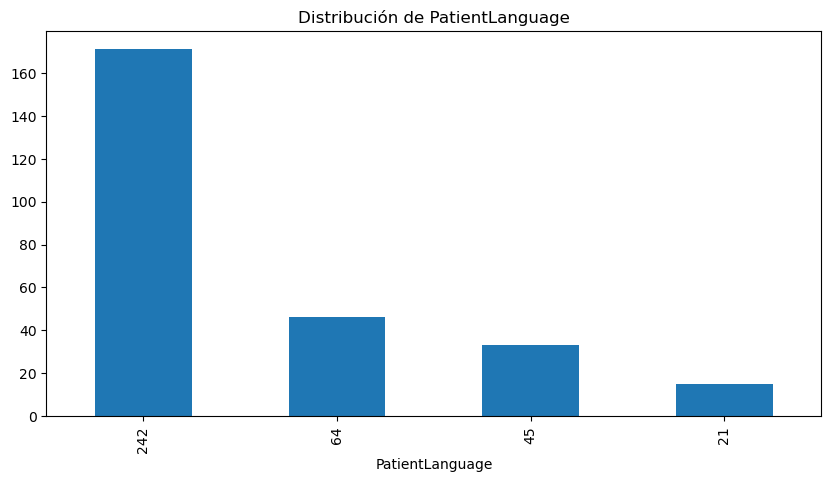

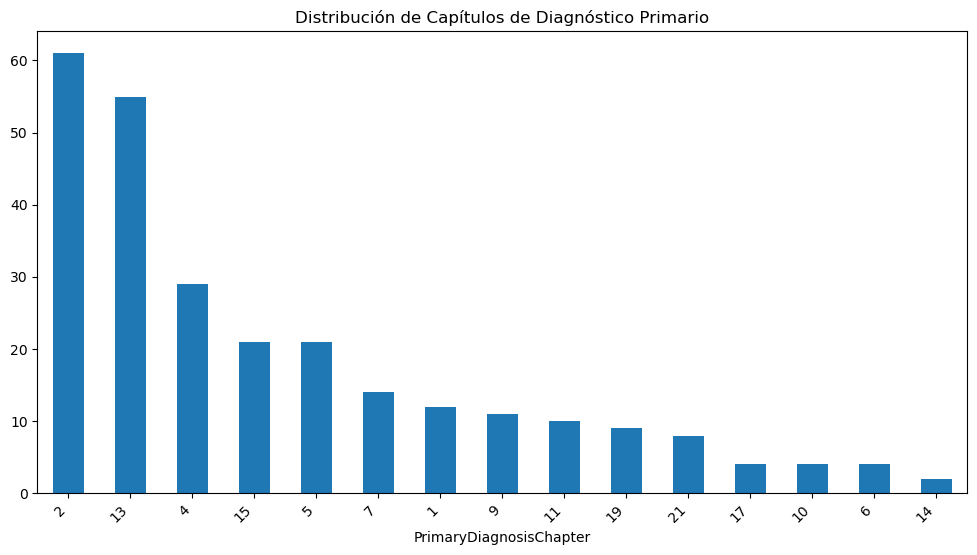

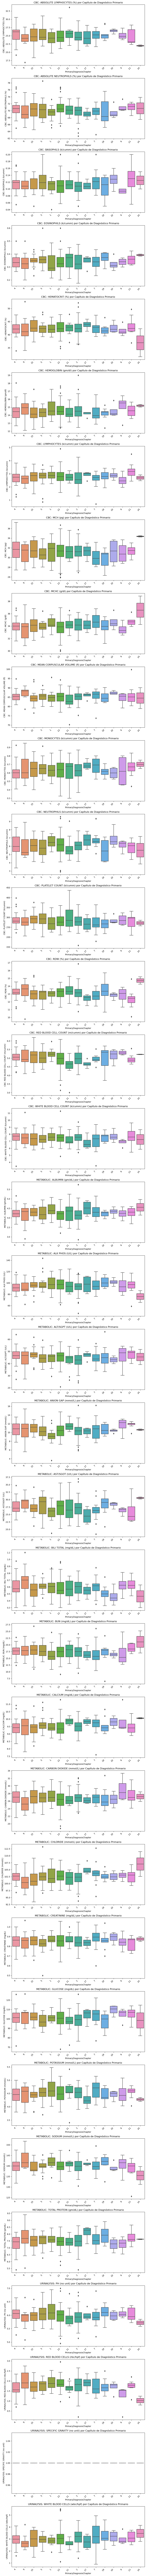

KeyError: 0

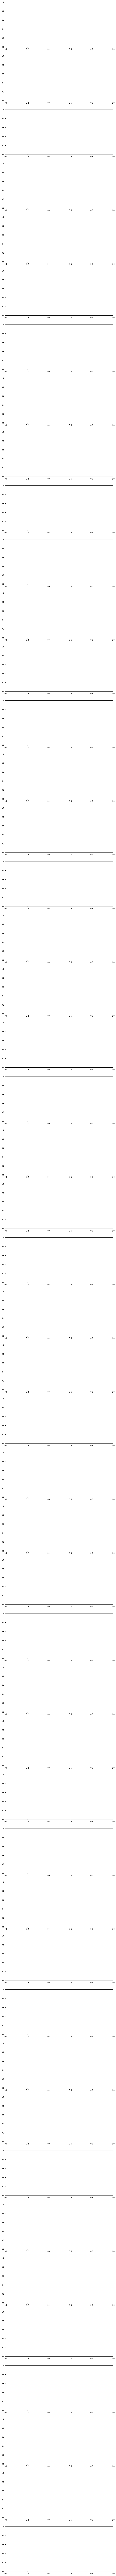

In [20]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Cargar los datos
# Asumimos que tienes tu dataframe en un archivo CSV llamado 'datos.csv'

# 1. Visión general de los datos
print("Dimensiones del dataframe:", df.shape)
print("\nTipos de datos:\n", df.dtypes)
#print("\nValores nulos:\n", df.isnull().sum())

# 2. Análisis estadístico descriptivo
print("\nEstadísticas descriptivas:\n", df.describe())

# Para variables categóricas
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(f"\nDistribución de {col}:\n", df[col].value_counts(normalize=True))

# 3. Visualización de distribuciones
# Para variables numéricas
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
fig, axes = plt.subplots(len(num_cols), 1, figsize=(10, 5*len(num_cols)))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

# Para variables categóricas
fig, axes = plt.subplots(len(cat_cols), 1, figsize=(10, 5*len(cat_cols)))
for i, col in enumerate(cat_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

# 4. Análisis de correlaciones
corr_matrix = df[num_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# 5. Análisis temporal
df['AdmissionStartDate'] = pd.to_datetime(df['AdmissionStartDate'])
df['AdmissionEndDate'] = pd.to_datetime(df['AdmissionEndDate'])

plt.figure(figsize=(10, 5))
sns.histplot(df['AdmissionDuration'])
plt.title('Distribución de la Duración de Admisión')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df['TimeSinceLastAdmission'])
plt.title('Distribución del Tiempo desde la Última Admisión')
plt.show()

# 6. Análisis demográfico
plt.figure(figsize=(10, 5))
sns.histplot(df['Edad'])
plt.title('Distribución de Edad')
plt.show()

for col in ['PatientGender_Female', 'PatientGender_Male', 'PatientRace', 'PatientLanguage']:
    plt.figure(figsize=(10, 5))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribución de {col}')
    plt.show()

# 7. Análisis de diagnósticos
plt.figure(figsize=(12, 6))
df['PrimaryDiagnosisChapter'].value_counts().plot(kind='bar')
plt.title('Distribución de Capítulos de Diagnóstico Primario')
plt.xticks(rotation=45, ha='right')
plt.show()

# 8. Análisis de resultados de laboratorio
lab_cols = [col for col in df.columns if col.startswith(('CBC:', 'METABOLIC:', 'URINALYSIS:'))]
fig, axes = plt.subplots(len(lab_cols), 1, figsize=(10, 5*len(lab_cols)))
for i, col in enumerate(lab_cols):
    sns.boxplot(x='PrimaryDiagnosisChapter', y=col, data=df, ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_title(f'{col} por Capítulo de Diagnóstico Primario')
plt.tight_layout()
plt.show()

# 9. Detección de valores atípicos
fig, axes = plt.subplots(len(num_cols), 1, figsize=(10, 5*len(num_cols)))
for i, col in enumerate(num_cols):
    sns.boxplot(df[col], ax=axes[i])
    axes[i].set_title(f'Box Plot de {col}')
plt.tight_layout()
plt.show()

# 10. Análisis de variables categóricas
marital_status_cols = [col for col in df.columns if col.startswith('PatientMaritalStatus_')]
fig, axes = plt.subplots(len(marital_status_cols), 1, figsize=(10, 5*len(marital_status_cols)))
for i, col in enumerate(marital_status_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier



# 1. Análisis de la distribución de PrimaryDiagnosisChapter
plt.figure(figsize=(12, 6))
df['PrimaryDiagnosisChapter'].value_counts().plot(kind='bar')
plt.title('Distribución de PrimaryDiagnosisChapter')
plt.xlabel('PrimaryDiagnosisChapter')
plt.ylabel('Frecuencia')
plt.show()

print("Distribución de PrimaryDiagnosisChapter:")
print(df['PrimaryDiagnosisChapter'].value_counts(normalize=True))

# 2. Separar características y variable objetivo
X = df.drop(['PrimaryDiagnosisChapter', 'PrimaryDiagnosisCode', 'AdmissionStartDate', 'AdmissionEndDate', 'PatientID'], axis=1)
y = df['PrimaryDiagnosisChapter']

# 3. Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Entrenar un modelo dummy que siempre predice la clase más frecuente
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train)

# 6. Evaluar el modelo dummy
dummy_pred = dummy_clf.predict(X_test_scaled)
print("\nInforme de clasificación del modelo dummy:")
print(classification_report(y_test, dummy_pred))

# 7. Análisis de correlación con la variable objetivo
correlation = df.corr()['PrimaryDiagnosisChapter'].sort_values(ascending=False)
print("\nCorrelaciones más altas con PrimaryDiagnosisChapter:")
print(correlation.head(10))
print("\nCorrelaciones más bajas con PrimaryDiagnosisChapter:")
print(correlation.tail(10))

# 8. Visualización de características importantes
plt.figure(figsize=(12, 8))
correlation.plot(kind='bar')
plt.title('Correlación de características con PrimaryDiagnosisChapter')
plt.xlabel('Características')
plt.ylabel('Correlación')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 9. Análisis de la separabilidad de las clases
features_to_plot = correlation.head(5).index.tolist()
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='PrimaryDiagnosisChapter', y=feature, data=df)
    plt.title(f'{feature} vs PrimaryDiagnosisChapter')
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Asumiendo que tu dataframe se llama 'df'
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'object']).columns
correlation_matrix = df[numeric_columns].corr()

# Crear un mapa de calor
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Mapa de calor de correlaciones')
plt.show()

ValueError: could not convert string to float: '016A590E-D093-4667-A5DA-D68EA6987D93'

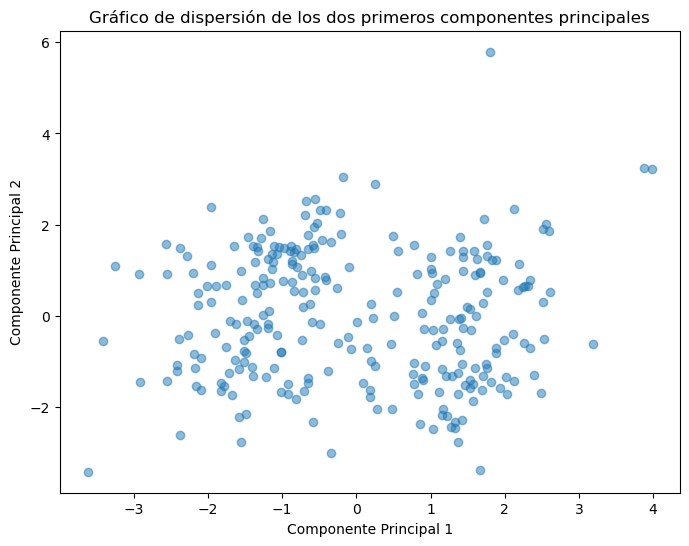

Varianza explicada por cada componente: [0.04947447 0.0427208  0.04226295 0.03902573 0.03891591]


In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Suponiendo que 'df' es tu dataframe

# Selecciona solo las columnas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Estandariza las variables numéricas
x = StandardScaler().fit_transform(df_numeric)

# Aplica PCA para 5 componentes principales
pca = PCA(n_components=5) # Ahora estamos solicitando 5 componentes
principalComponents = pca.fit_transform(x)

# Crea un nuevo dataframe con los componentes principales
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Visualiza los componentes principales
plt.figure(figsize=(8,6))
plt.scatter(principalDf['PC1'], principalDf['PC2'], alpha=0.5) # Solo mostramos 2 para el gráfico
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Gráfico de dispersión de los dos primeros componentes principales')
plt.show()

# Imprime la varianza explicada por cada componente
print(f'Varianza explicada por cada componente: {pca.explained_variance_ratio_}')



In [25]:
# Continuando con el código anterior después de ajustar PCA...

# Imprime los componentes principales
print("Componentes principales:")
print(pca.components_)

# Para cada componente principal, imprime las variables originales que más contribuyen
for i, component in enumerate(pca.components_):
    component_contributions = pd.Series(component, index=df_numeric.columns).sort_values(ascending=False)
    print(f"\nComponente {i+1}:")
    print(component_contributions.head())  # Muestra las 5 variables con mayor peso en el componente


Componentes principales:
[[ 2.38002591e-02 -6.44441383e-02  6.78536866e-02  1.03684283e-02
   8.96496583e-03  6.53583394e-03  1.47758375e-01  9.91348454e-02
   4.44648803e-02 -1.92079605e-01  5.32741381e-02 -2.16748394e-02
  -7.18330212e-02  1.61539176e-01  6.60934022e-02 -2.08524858e-01
   3.10337206e-02 -1.06463620e-02  2.23751867e-02  1.62707965e-02
  -7.13157097e-02 -7.68657195e-02 -7.69993118e-02 -6.92480090e-02
   1.45131762e-01 -3.08438393e-02  7.92618331e-02 -6.11320414e-02
   8.78040747e-02  9.96239249e-02 -5.14126135e-02  7.14066888e-02
  -1.43155247e-01 -9.86076132e-32  2.95418076e-02 -8.12687434e-02
  -1.14351164e-01 -1.24375159e-01 -1.23732533e-01  5.64582668e-01
  -5.64582668e-01 -1.33504191e-01  7.49490316e-02  3.64655818e-02
   4.80725828e-02 -4.57136397e-02 -1.28243455e-01  3.72128168e-02
  -1.39140350e-02]
 [-4.91199364e-02 -2.08237907e-01 -1.31804135e-02 -5.24707173e-02
  -3.69636312e-02  1.09261075e-01  5.84930693e-02  8.66460755e-02
   9.72267136e-02 -1.27909511e-0

In [27]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Suponiendo que 'df' es tu dataframe y 'PrimaryDiagnosisChapter' es la columna objetivo

# Primero, estandariza las variables para tener una media de 0 y una varianza de 1
features = df.columns.difference(['PrimaryDiagnosisChapter'])
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Aplica PCA
pca = PCA(n_components=2) # n_components es el número de componentes principales que deseas
principalComponents = pca.fit_transform(x)

# Crea un nuevo dataframe con los componentes principales
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

# Visualiza los componentes principales
plt.figure(figsize=(8,6))
plt.scatter(principalDf['PC1'], principalDf['PC2'])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Gráfico de dispersión de los dos primeros componentes principales')
plt.show()

# Imprime la varianza explicada por cada componente
print(f'Varianza explicada por cada componente: {pca.explained_variance_ratio_}')


TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que 'df' es tu dataframe

# Calcula la matriz de correlación
correlation_matrix = df.corr()

# Visualiza la matriz de correlación
sns.heatmap(correlation_matrix, annot=True)
plt.show()

# Selecciona una variable para el gráfico de dispersión
variable = 'CBC: ABSOLUTE LYMPHOCYTES (%)'

# Crea un gráfico de dispersión
sns.scatterplot(data=df, x=variable, y='PrimaryDiagnosisChapter')
plt.show()


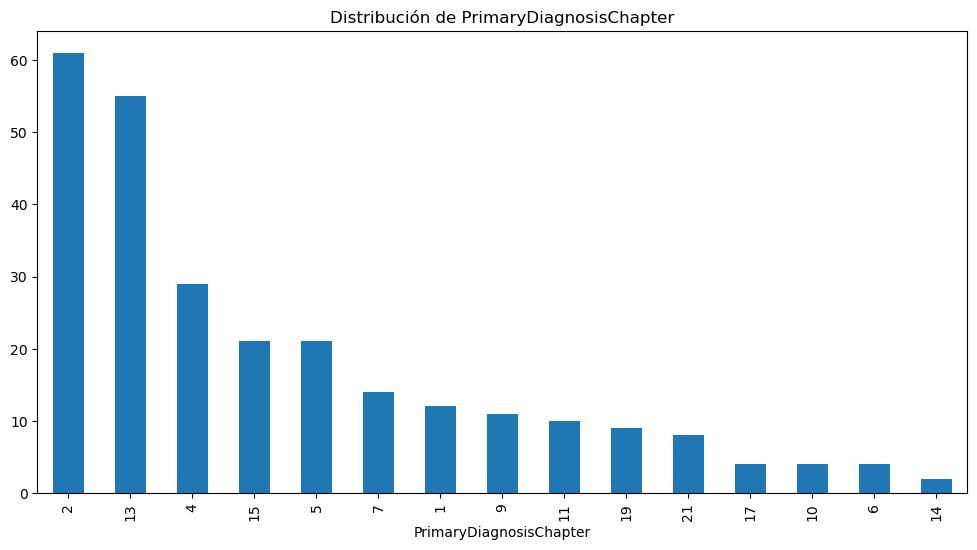

In [30]:
plt.figure(figsize=(12, 6))
df['PrimaryDiagnosisChapter'].value_counts().plot(kind='bar')
plt.title('Distribución de PrimaryDiagnosisChapter')
plt.show()

In [32]:
from scipy import stats

for col in numeric_columns:
    groups = [group for _, group in df.groupby('PrimaryDiagnosisChapter')[col]]
    f_value, p_value = stats.f_oneway(*groups)
    print(f"ANOVA para {col}: F-value: {f_value}, p-value: {p_value}")

ANOVA para CBC: ABSOLUTE LYMPHOCYTES (%): F-value: 1.1005695958245596, p-value: 0.35749592009179504
ANOVA para CBC: ABSOLUTE NEUTROPHILS (%): F-value: 0.8793887221989574, p-value: 0.5819300438239565
ANOVA para CBC: BASOPHILS (k/cumm): F-value: 0.9624121912607885, p-value: 0.49258052177097156
ANOVA para CBC: EOSINOPHILS (k/cumm): F-value: 0.8049971625514271, p-value: 0.6634739260650373
ANOVA para CBC: HEMATOCRIT (%): F-value: 0.8274641705962976, p-value: 0.638915541578793
ANOVA para CBC: HEMOGLOBIN (gm/dl): F-value: 0.6064330288461999, p-value: 0.8588796013277409
ANOVA para CBC: LYMPHOCYTES (k/cumm): F-value: 0.9507407904760575, p-value: 0.5048841947618814
ANOVA para CBC: MCH (pg): F-value: 1.2772491071631618, p-value: 0.22170312485205254
ANOVA para CBC: MCHC (g/dl): F-value: 1.4397235017428784, p-value: 0.13511785525584108
ANOVA para CBC: MEAN CORPUSCULAR VOLUME (fl): F-value: 0.8025456838022642, p-value: 0.6661428740976362
ANOVA para CBC: MONOCYTES (k/cumm): F-value: 0.683050478626636

C:\Users\piran\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


ValueError: could not convert string to float: '03A481F5-B32A-4A91-BD42-43EB78FEBA77'

In [ ]:
df.columns

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


# Preparar los datos
X = df[numeric_columns]
y = df['PrimaryDiagnosisChapter_encoded']

# Entrenar el modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Obtener importancia de características
importances = pd.DataFrame({'feature': numeric_columns, 'importance': rf.feature_importances_})
importances = importances.sort_values('importance', ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances.head(10))
plt.title('Top 10 características más importantes')
plt.show()

KeyError: 'PrimaryDiagnosisChapter_encoded'